# QDM window size analysis

Comparison of the different window sizes for grouping. 

In [1]:
# config cell
from pathlib import Path
import numpy as np
import seaborn as sns
import xarray as xr
from scipy.stats import cramervonmises_2samp

era5_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/era5_zarr")

# tmp dir for writing downscaled data
tmp_dir = Path("/center1/CMIP6/kmredilla/downscaling/eda")

# template filename for downscaled outputs
tmp_fn = "qmw{qm_window}_{var_id}_{model}_{scenario}.zarr"

# era5 precip indicators file
# processed in full_domain_preprocessing.ipynb
era5_idx_fp = tmp_dir.joinpath("pridx_era5.zarr")

window_sizes = [31, 45, 61, 91]

In [2]:
# run the pixelwise Cramer von mises test for the Rx1day indicator for the different window sizes and combine
era5_idx = xr.open_zarr(era5_idx_fp)
era5_idx.load()

var_id = "pr"
models = ["GFDL-ESM4", "NorESM2-MM", "EC-Earth3-Veg"]
cvm_datasets = []
for window in window_sizes:
    for model in models:
        hist_idx = xr.open_zarr(
            tmp_dir.joinpath(
                tmp_fn.format(
                    qm_window=window,
                    var_id=var_id + "idx",
                    model=model,
                    scenario="historical",
                )
            )
        )

        hist_idx = (
            hist_idx.isel(experiment=0, drop=True)
            .assign_coords(model=model)
            .expand_dims("model")
        )
        hist_idx.load()

        cvm = cramervonmises_2samp(
            hist_idx["rx1day"].values.squeeze(),
            era5_idx["rx1day"].values.squeeze(),
            method="asymptotic",
        )

        dims = {dim: size for dim, size in hist_idx.sizes.items() if dim != "time"}
        new_ds = xr.Dataset(
            {
                "pvalue": (dims.keys(), np.expand_dims(cvm.pvalue, axis=[0, 1])),
            },
            coords={dim: hist_idx.coords[dim] for dim in dims.keys()},
        )
        cvm_datasets.append(new_ds)

cvm_win_ds = xr.merge(cvm_datasets)

### Domain-wide boxplots of 2-sample Cramér–von Mises $p$-values for four different day-of-year grouping window sizes

<Axes: xlabel='model', ylabel='pvalue'>

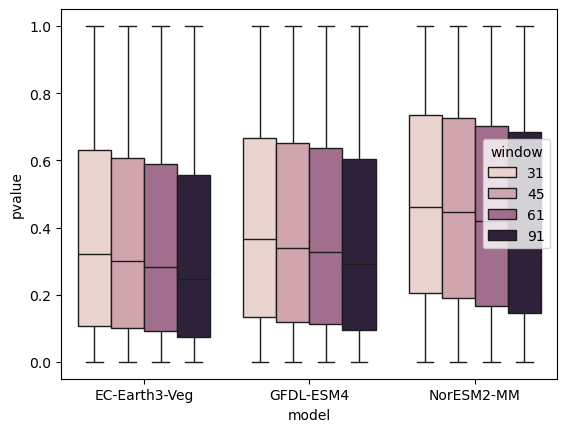

In [3]:
df = cvm_win_ds.to_dataframe().reset_index()[["model", "window", "pvalue"]]
sns.boxplot(df, x="model", y="pvalue", hue="window")

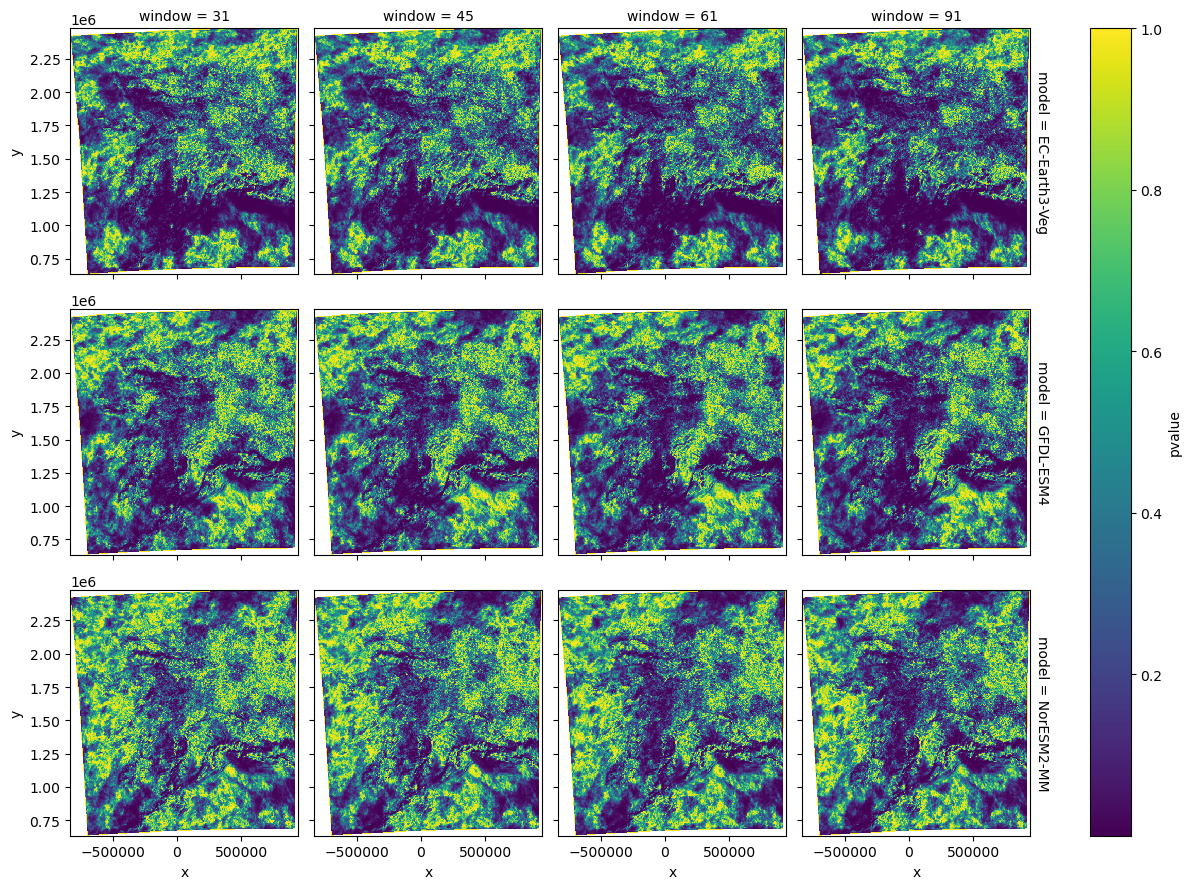

In [4]:
cvm_win_ds["pvalue"].plot(col="window", row="model", cmap="viridis")